In [32]:
from PIL import Image, ImageDraw
from skimage.filters import threshold_otsu, threshold_sauvola  # I am not quite sure yet if otsu is the best binarization
import numpy as np
from IPython.display import display
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import os
import pickle
from sklearn.metrics import auc
import matplotlib.pyplot as plt

from keyword_spotting_lib import *

In [78]:
images_path = "images"
imgs_comp = {f: np.array(Image.open(f"images/{f}")) for f in os.listdir(images_path)}


In [79]:
def binarize(i, t):
    """Binarize an image (as numpy array) using the given threshold."""

    thresholded_im = np.zeros(i.shape)
    thresholded_im[i >= t] = 1
    return thresholded_im

binarized_imgs_comp = {k: binarize(v, threshold_otsu(v)) for (k, v) in imgs_comp.items()}

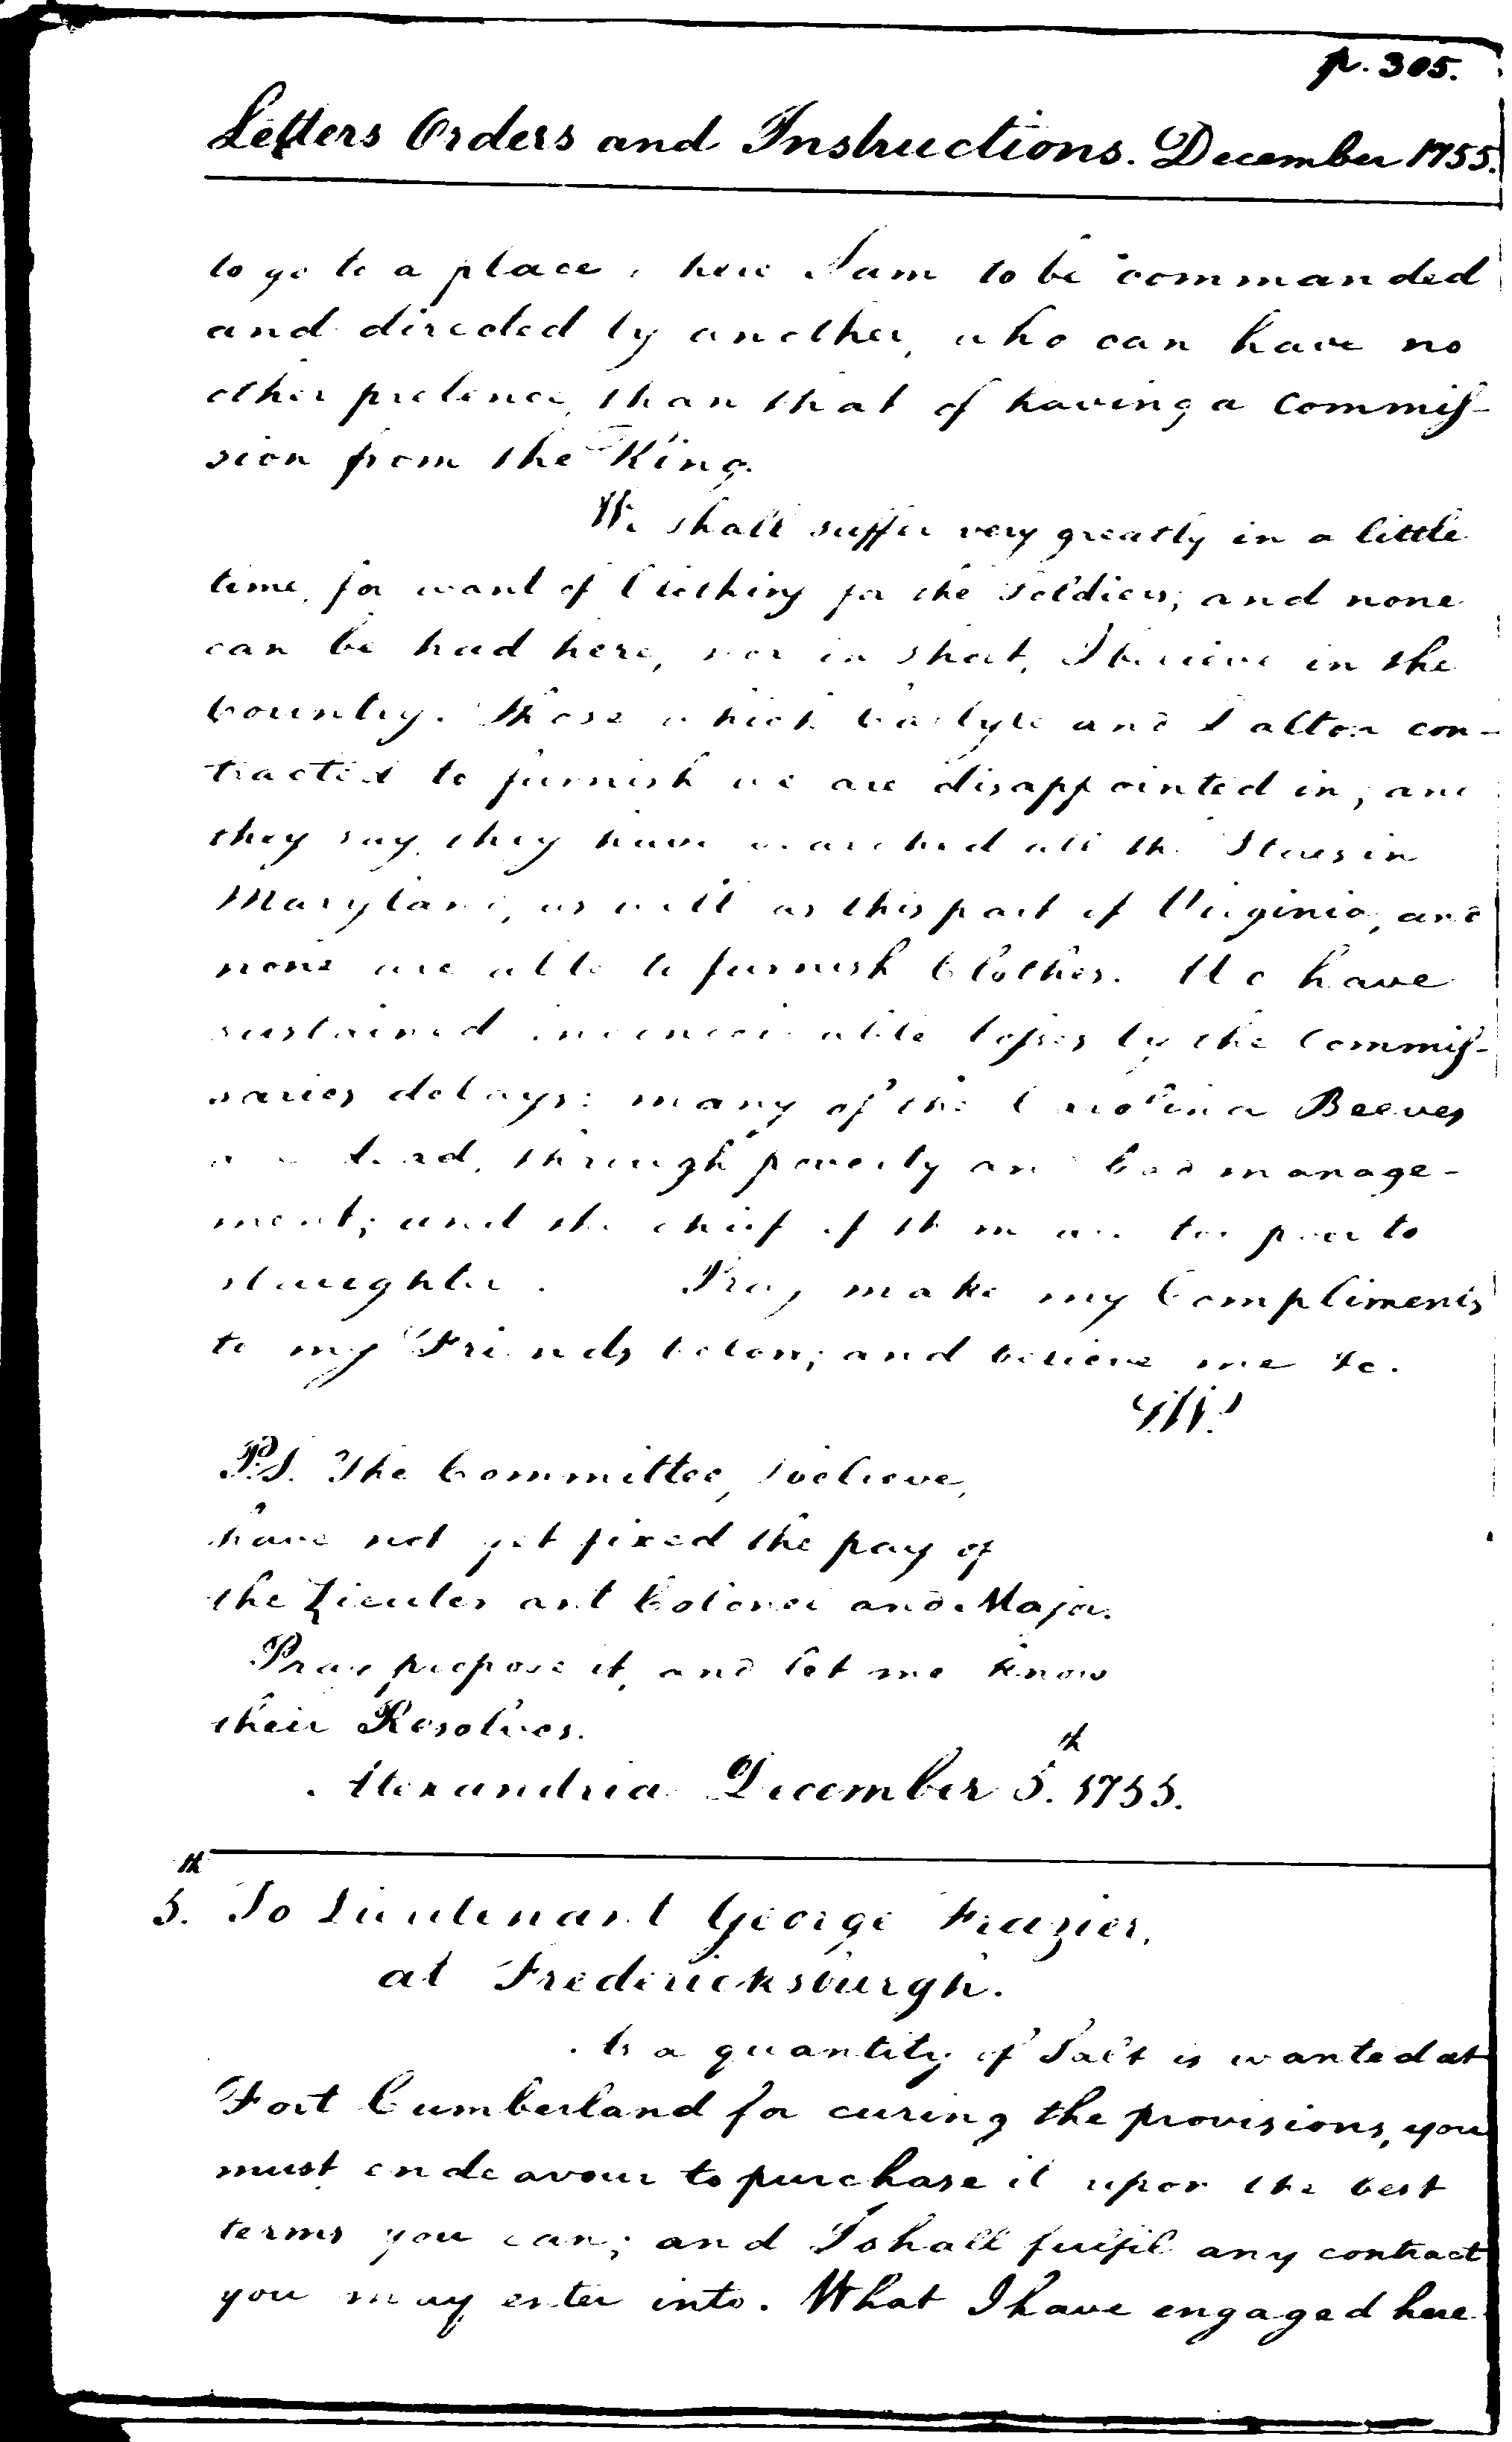

In [80]:
Image.fromarray(binarized_imgs_comp["305.jpg"].astype('uint8')*255)

In [81]:

def crop_images(imgs):
    locations_path = "competition_data/ground-truth"
    polygons = {f: parse_svg(f"{locations_path}/{f}") for f in os.listdir(locations_path)}

    # cut out every word for every image
    return {
        name: [
            cut_word(Image.fromarray(img.astype('uint8')*255), pol)
                for pol in polygons[f"{name.replace('jpg', 'svg')}"]
        ] for (name, img) in imgs.items()
    }



try:
    with open("pickled_comp/binarized_imgs_comp", "rb") as f:
        words = pickle.load(f)

except FileNotFoundError:
    words = crop_images(binarized_imgs_comp)

    with open("pickled_comp/binarized_imgs_comp", "wb") as f:
        pickle.dump(words, f)

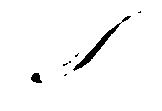

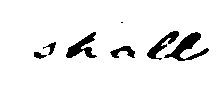

In [82]:
display(words["305.jpg"][13], words["306.jpg"][100])

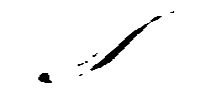

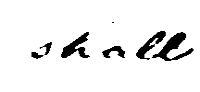

In [83]:
def resize(img, width=200):
    return img.resize((width, img.size[1]))

words_resized = {f: [resize(i) for i in words[f]] for f in words.keys()}
display(words_resized["305.jpg"][13], words_resized["306.jpg"][100])

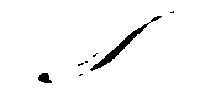

In [84]:
binarized_words_resized = {f: [binarize(np.array(i), threshold_otsu(np.array(i))) for i in words_resized[f]] for f in words_resized.keys()}
display(Image.fromarray(binarized_words_resized["305.jpg"][13].astype("uint8")*255))

In [87]:

def remove_pt(word):
    filter_ = ["-s_cm", "-s_pt", "-s_qo", "-s_qt", "-s_sq"]
    if any(word.endswith(pt) for pt in filter_):
        index = max(word.find(pt) for pt in filter_)
        return word[:index]

    return word

def mapping():
    with open("competition_data/task/keywords.txt", "r") as t:
        # mapping "position -> word" (not the other way around since word may not be unique)
        pos_to_word = {name: remove_pt(word) for (word, name) in [l.strip().split(",") for l in t]}
    
        # get all page numbers
        pages = {k.split("-", 1)[0] for k in pos_to_word.keys()}
        # construct a dict like this: {"270": {"270-01-01": 0, "270-01-02": 1, ...}, "271": ...}
        pos_to_index = {p: {
            k: j for (j, k) in enumerate(sorted([
                i for i in pos_to_word.keys() if i.startswith(p)
            ]))} for p in pages}

    def f(word):
        # reverse-search mapping to find all positions of words
        positions = [(page, pos) for page in pos_to_index.keys()
                        for pos in pos_to_index[page].keys()
                        if pos_to_word[pos] == word]

        return [(f"{page}.jpg", pos_to_index[page][pos]) for (page, pos) in positions]

    return f


word_to_index = mapping()

"""

# let's get all keywords in a list
with open("competition_data/task/keywords.txt", "r") as keywords_file:
    keywords_list = [remove_pt(line.split(',')[0].strip() ) for line in keywords_file]

keywords_list_helper = [x for x in keywords_list]
print(keywords_list_helper)

for x in keywords_list_helper:
    print(x)
    
    
# get a list of images of the keywords (depending of the set we take the images from)
images_keywords_in_valid = []
for x in keywords_list_helper:
    images_keywords_helperv = [words[k][i] for (k, i) in word_to_index(x) if k.startswith("3")]
    if images_keywords_helperv == []:
        #print("valid:",x)
        keywords_list.remove(x)
    else:
        images_keywords_in_valid.append(images_keywords_helperv[0])

images_keywords_in_train = []
for x in keywords_list:
    images_keywords_helpert = [words[k][i] for (k, i) in word_to_index(x) if not k.startswith("3")]
    if images_keywords_helpert == []:
        print("train:", x)
    else:
        images_keywords_in_train.append(images_keywords_helpert[0])

# get a list of images form the train or valid set
with open("task/train.txt") as f:
    train = [l.strip() for l in f]
images_train_set = [i for (k, v) in words.items() for i in v if any(t for t in train if k.startswith(t))]
images_train = [(k,j) for (k, v) in words.items() for (j,i) in enumerate(v) if any(t for t in train if k.startswith(t))]
j = 0
images_train_index = []
for x in images_train:
    images_train_index.append((images_train[j], j))
    j = j + 1

with open("competition_data/task/test.txt") as f:
    valid = [l.strip() for l in f]
images_valid_set = [i for (k, v) in words.items() for i in v if any(t for t in valid if k.startswith(t))]
images_valid = [(k,j) for (k, v) in words.items() for (j,i) in enumerate(v) if any(t for t in valid if k.startswith(t))]
i = 0
images_valid_index = []
for x in images_valid:
    images_valid_index.append((images_valid[i], i))
    i = i + 1
    
    

images_keywords_in_valid = images_keywords_in_valid[0:4]


distMat_train_keywords = np.zeros((len(images_train_set), len(images_keywords_in_valid)))
i = 0
for x in images_keywords_in_valid:
    j = 0
    x = np.array(x.resize((x.size[1], 100)))
    for y in images_train_set:
        y = np.array(y.resize((y.size[1], 100)))
        distance, path = fastdtw(x.T, y.T, dist=euclidean)
        distMat_train_keywords[j][i] = distance
        j = j+1
    i= i+1
"""

distMat_train_keywords = dist_mat(images_train_set, images_keywords_in_valid)
"""


#calculate for the images above the distance matrices with the train or valid set

images_keywords_in_train = images_keywords_in_train[0:4]

distMat_valid_keywords = np.zeros((len(images_valid_set), len(images_keywords_in_train)))
i = 0
for x in images_keywords_in_train:
    j = 0
    x = np.array(x.resize((x.size[1], 100)))
    for y in images_valid_set:
        y = np.array(y.resize((y.size[1], 100)))
        distance, path = fastdtw(x.T, y.T, dist=euclidean)
        distMat_valid_keywords[j][i] = distance
        j = j+1
    i= i+1
"""

distMat_valid_keywords = dist_mat(images_valid_set, images_keywords_in_train)
"""

"""

'\n\n'

In [88]:
distMat_valid_keywords.min()

ValueError: zero-size array to reduction operation minimum which has no identity

In [89]:
# Evaluation of the Data

# For each image and each threshold (top-k matches), compute the TP, FP, FN
# Recall = TP / (TP + FN)
# Precision = TP / (TP + FP)
# Average Precision (AP): Area under the Recall-Precision curve

keywords_list = keywords_list[0:4]


# now we can start the evaluation
def evaluation(dist_train_keywords, dist_valid_keywords, topkmatches):
    if topkmatches > len(images_valid_set):
        maxk = len(images_valid_set)
    else:
        maxk = topkmatches
    
    tp_train = np.zeros((maxk, len(keywords_list)))
    fp_train = np.zeros((maxk, len(keywords_list)))
    fn_train = np.zeros((maxk, len(keywords_list)))
    precision_train = np.zeros((maxk, len(keywords_list)))
    recall_train = np.zeros((maxk, len(keywords_list)))

    tp_valid = np.zeros((maxk, len(keywords_list)))
    fp_valid = np.zeros((maxk, len(keywords_list)))
    fn_valid = np.zeros((maxk, len(keywords_list)))
    precision_valid = np.zeros((maxk, len(keywords_list)))
    recall_valid = np.zeros((maxk, len(keywords_list)))

    index = 0
    # we start with the train set
    for keyword in keywords_list:

        # all ID's of the keyword in the train set
        keyword_ids = [(k, i) for (k, i) in word_to_index(keyword) if not k.startswith("3")]

        for k in range(maxk):
            # get the k smallest indices
            idx = np.argpartition(dist_train_keywords[:,index],k+1)[:(k+1)]
            # match the indices from the distMat with the images ID
            kmatches_ids = [x for (x, j) in images_train_index for i in idx if i==j]
            # adjust the fp, tp and fn
            if (k == 3) and (keyword == 'C-l-o-t-h-i-n-g'):
                print(keyword)
                print(keyword_ids)
                print(idx)
                print(kmatches_ids)
            
            for x in kmatches_ids:
                if x in keyword_ids:
                    tp_train[k,index] = tp_train[k,index]+1
                else:
                    fp_train[k,index] = fp_train[k,index]+1
            fn_train[k,index] = len(keyword_ids)-tp_train[k,index]

            precision_train[k,index] = tp_train[k,index]/(tp_train[k,index] + fp_train[k,index])
            recall_train[k,index] = tp_train[k,index]/(tp_train[k,index] + fn_train[k,index])
        
        index = index + 1
        
    index = 0
    # now the valid set
    for keyword in keywords_list:
        # all ID's of the keyword in the valid set
        keyword_ids = [(k, i) for (k, i) in word_to_index(keyword) if k.startswith("3")]

        for k in range(maxk):
            # get the k smallest indices
            idx = np.argpartition(dist_valid_keywords[:,index],k+1)[:(k+1)]
            # match the indices from the distMat with the images ID
            kmatches_ids = [x for (x, j) in images_valid_index for i in idx if i==j]
            # adjust the fp, tp and fn
            for x in kmatches_ids:
                if x in keyword_ids:
                    tp_valid[k,index] = tp_valid[k,index]+1
                else:
                    fp_valid[k,index] = fp_valid[k,index]+1
            fn_valid[k,index] = len(keyword_ids)-tp_valid[k,index]

            precision_valid[k,index] = tp_valid[k,index]/(tp_valid[k,index] + fp_valid[k,index])
            recall_valid[k,index] = tp_valid[k,index]/(tp_valid[k,index] + fn_valid[k,index])

        index = index + 1
    
    return precision_train, recall_train, precision_valid, recall_valid



In [61]:
precision_t, recall_t, precision_v, recall_v = evaluation(distMat_train_keywords, distMat_valid_keywords, 20)

#print(precision_t[-2:,:])
#print(precision_v[-2:,:])
#print(recall_t[-2:,:])
#print(recall_v[-2:,:])

In [62]:
images_keywords_test = [words[k][i] for (k, i) in word_to_index('V-i-r-g-i-n-i-a') if k.startswith("3")]
images_test_set = [words["271.jpg"][182], words["275.jpg"][45], words["275.jpg"][47], words["275.jpg"][256], words["273.jpg"][133], words["272.jpg"][79]]
images_test_set.append(images_keywords_test[0])

display(*images_keywords_test)
for x in images_test_set:
    display(x)



distMat_test_keywords = np.zeros((len(images_test_set), len(images_keywords_test)))
i = 0
for x in images_keywords_test:
    j = 0
    x = np.array(x.resize((x.size[1], 100)))
    for y in images_test_set:
        y = np.array(y.resize((y.size[1], 100)))
        distance, path = fastdtw(x.T, y.T, dist=euclidean)
        distMat_test_keywords[j][i] = distance
        j = j+1
    i= i+1

print(distMat_test_keywords)

KeyError: '271.jpg'

In [63]:
plt.plot(recall_t[:,0],precision_t[:,0])
plt.plot(recall_v[:,0],precision_v[:,0])
plt.legend(['First Image in Train', 'First Image in Validation'], loc='upper right')
plt.xlabel('Recall')
plt.ylabel('Precision')
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
plt.show

auc_first_image_train = auc(recall_t[:,0],precision_t[:,0])
print("AP First Image in Train:", auc_first_image_train)

IndexError: index 0 is out of bounds for axis 1 with size 0